## Load in your data and imports

In [13]:
import pandas as pd
import metpy.calc as mpcalc
import matplotlib.pyplot as plt
from metpy.units import units
from metpy.interpolate import interpolate_to_grid
from datetime import datetime,timedelta
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
from metpy.plots import USCOUNTIES
from metpy.calc import wind_components, reduce_point_density
from metpy.units import units
from metpy.plots import StationPlot

In [14]:
nysm_df = pd.read_csv('/nfs/home11/ugrad/2020/ec618847/researchmay15/20180515_2.csv')
nysm_sites = pd.read_csv('/spare11/atm533/data/nysm_sites.csv')

### take a peak at the data

In [15]:
nysm_df.head()

,stid,time,temp_2m [degF],relative_humidity [percent],precip_incremental [inch],avg_wind_speed_prop [mile/hr],max_wind_speed_prop [mile/hr],wind_speed_stddev_prop [mile/hr],wind_direction_prop [degrees],wind_direction_stddev_prop [degrees],avg_wind_speed_sonic [mile/hr],max_wind_speed_sonic [mile/hr],wind_speed_stddev_sonic [mile/hr],wind_direction_sonic [degrees],wind_direction_stddev_sonic [degrees],station_pressure [inHg]
0,ADDI,2018-05-15 00:00:00 EDT,59.7,90.8,0.0,2.0,3.2,0.6,179.0,24.0,2.4,3.6,0.6,178.0,26.0,28.18
1,ADDI,2018-05-15 00:05:00 EDT,58.8,91.5,0.0,1.5,3.0,0.6,209.0,30.0,1.8,3.3,0.7,202.0,29.0,28.18
2,ADDI,2018-05-15 00:10:00 EDT,60.2,91.3,0.0,3.1,4.1,0.6,187.0,16.0,3.4,5.0,0.8,185.0,14.0,28.18
3,ADDI,2018-05-15 00:15:00 EDT,59.6,88.7,0.0,2.3,3.5,0.6,189.0,21.0,2.7,3.9,0.6,187.0,22.0,28.18
4,ADDI,2018-05-15 00:20:00 EDT,61.1,89.5,0.0,3.1,4.5,0.6,177.0,17.0,3.5,5.6,0.8,175.0,17.0,28.18


#### Redefine with less data!

In [16]:
df = nysm_df[['stid', 'time', 'temp_2m [degF]', 'relative_humidity [percent]'
              , 'avg_wind_speed_prop [mile/hr]', 'wind_direction_prop [degrees]'
              , 'station_pressure [inHg]']]  

In [17]:
df.head()

,stid,time,temp_2m [degF],relative_humidity [percent],avg_wind_speed_prop [mile/hr],wind_direction_prop [degrees],station_pressure [inHg]
0,ADDI,2018-05-15 00:00:00 EDT,59.7,90.8,2.0,179.0,28.18
1,ADDI,2018-05-15 00:05:00 EDT,58.8,91.5,1.5,209.0,28.18
2,ADDI,2018-05-15 00:10:00 EDT,60.2,91.3,3.1,187.0,28.18
3,ADDI,2018-05-15 00:15:00 EDT,59.6,88.7,2.3,189.0,28.18
4,ADDI,2018-05-15 00:20:00 EDT,61.1,89.5,3.1,177.0,28.18


#### Define dataframe for the location/elevation data

In [18]:
df_loc = pd.read_csv('/spare11/atm533/data/nysm_sites.csv')

In [19]:
df_loc.head()

,stid,number,name,lat,lon,elevation,county,nearest_city,state,distance_from_town [km],direction_from_town [degrees],climate_division,climate_division_name,wfo,commissioned,decommissioned
0,ADDI,107,Addison,42.04036,-77.23726,507.6140,Steuben,Addison,NY,6.9,S,1,Western Plateau,BGM,2016-08-10 18:15:00 UTC,NaN
1,ANDE,111,Andes,42.18227,-74.80139,518.2820,Delaware,Andes,NY,1.5,WSW,2,Eastern Plateau,BGM,2016-08-04 15:55:00 UTC,NaN
2,BATA,24,Batavia,43.01994,-78.13566,276.1200,Genesee,Batavia,NY,4.9,ENE,9,Great Lakes,BUF,2016-02-18 18:40:00 UTC,NaN
3,BEAC,76,Beacon,41.52875,-73.94527,90.1598,Dutchess,Beacon,NY,3.3,NE,5,Hudson Valley,ALY,2016-08-22 16:45:00 UTC,NaN
4,BELD,90,Belden,42.22322,-75.66852,470.3700,Broome,Belden,NY,2.2,NNE,2,Eastern Plateau,BGM,2015-11-30 20:20:00 UTC,NaN


In [20]:
dfloc = df_loc[['stid', 'lat', 'lon', 'elevation']]

In [21]:
#merge the dataframes!!
df_merged = pd.merge(df, dfloc, left_on='stid', right_on='stid')

### In the cell below, define the time you want and variables

In [24]:
tempf = df_merged['temp_2m [degF]'].values * units('degF')
rh = df_merged['relative_humidity [percent]'].values * units('%')
pres = df_merged['station_pressure [inHg]'].values * units('inHg')
dewpoint = mpcalc.dewpoint_from_relative_humidity(tempf, rh)
df_merged['dewpoint'] = dewpoint
dewpointf = df_merged['dewpoint']*1.8+32
df_merged['dewpointf']=dewpointf
theta_e = mpcalc.equivalent_potential_temperature(pres, tempf, dewpoint)
df_merged['theta e'] = theta_e

In [25]:
df_merged

,stid,time,temp_2m [degF],relative_humidity [percent],avg_wind_speed_prop [mile/hr],wind_direction_prop [degrees],station_pressure [inHg],lat,lon,elevation,dewpoint,dewpointf,theta e
0,ADDI,2018-05-15 00:00:00 EDT,59.7,90.8,2.0,179.0,28.18,42.04036,-77.23726,507.614,13.894192,57.009546,322.490125
1,ADDI,2018-05-15 00:05:00 EDT,58.8,91.5,1.5,209.0,28.18,42.04036,-77.23726,507.614,13.517795,56.332031,321.196645
2,ADDI,2018-05-15 00:10:00 EDT,60.2,91.3,3.1,187.0,28.18,42.04036,-77.23726,507.614,14.253536,57.656365,323.513352
3,ADDI,2018-05-15 00:15:00 EDT,59.6,88.7,2.3,189.0,28.18,42.04036,-77.23726,507.614,13.479632,56.263337,321.634498
4,ADDI,2018-05-15 00:20:00 EDT,61.1,89.5,3.1,177.0,28.18,42.04036,-77.23726,507.614,14.439818,57.991673,324.462074
...,...,...,...,...,...,...,...,...,...,...,...,...,...
36283,YORK,2018-05-15 23:35:00 EDT,54.6,96.8,1.9,204.0,29.41,42.85504,-77.84776,177.942,12.060919,53.709654,310.929799
36284,YORK,2018-05-15 23:40:00 EDT,54.8,96.9,2.2,217.0,29.41,42.85504,-77.84776,177.942,12.187289,53.937120,311.257899
36285,YORK,2018-05-15 23:45:00 EDT,54.1,96.6,2.1,204.0,29.41,42.85504,-77.84776,177.942,11.752890,53.155202,310.129654
36286,YORK,2018-05-15 23:50:00 EDT,53.7,96.7,2.4,206.0,29.41,42.85504,-77.84776,177.942,11.547220,52.784995,309.560280


In [26]:
time1 = df_merged['time'] == '2018-05-15 13:00:00 EDT'
time1 = df_merged[time1]
lat = time1['lat']
lon = time1['lon']
td = time1['dewpointf']


#### Get rid of the NaN's

In [ ]:
time1[time1.isna().any(axis=1)]

In [27]:
time1 = time1.dropna()

In [28]:
#double check to make sure they are gone
time1[time1.isna().any(axis=1)]

,stid,time,temp_2m [degF],relative_humidity [percent],avg_wind_speed_prop [mile/hr],wind_direction_prop [degrees],station_pressure [inHg],lat,lon,elevation,dewpoint,dewpointf,theta e


#### Define your variables with the new dataframe without NaNs

In [30]:
td = time1['dewpointf']
lat = time1['lat']
lon = time1['lon']
wdiryes = time1['wind_direction_prop [degrees]'].values* units.degree
wspdyes = time1['avg_wind_speed_prop [mile/hr]'].values* units.mph
lats = time1['lat']
lons = time1['lon']

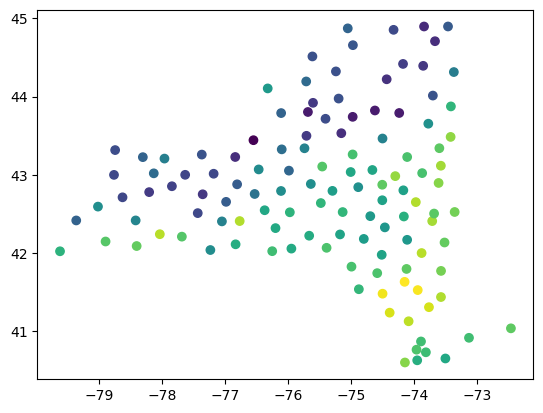

In [31]:
plt.scatter(lon, lat, c=td)

In [32]:
gridx, gridy, grid_dew = interpolate_to_grid(lon.values, lat.values, td.values, interp_type='cressman',
                                             minimum_neighbors=1, search_radius=0.5, hres=0.05)

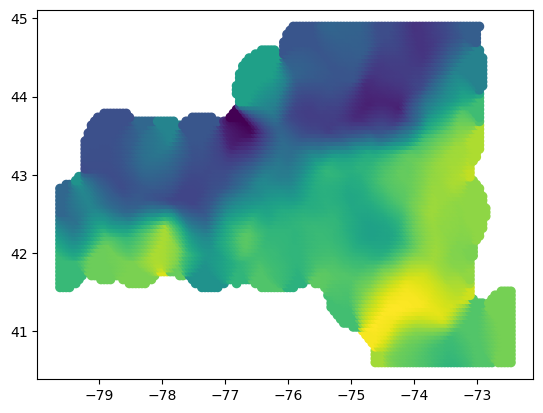

In [33]:
plt.scatter(gridx, gridy, c=grid_dew)

In [38]:
crs = ccrs.LambertConformal(central_longitude= -75, central_latitude=42)
clevels = np.arange(50,72,2)

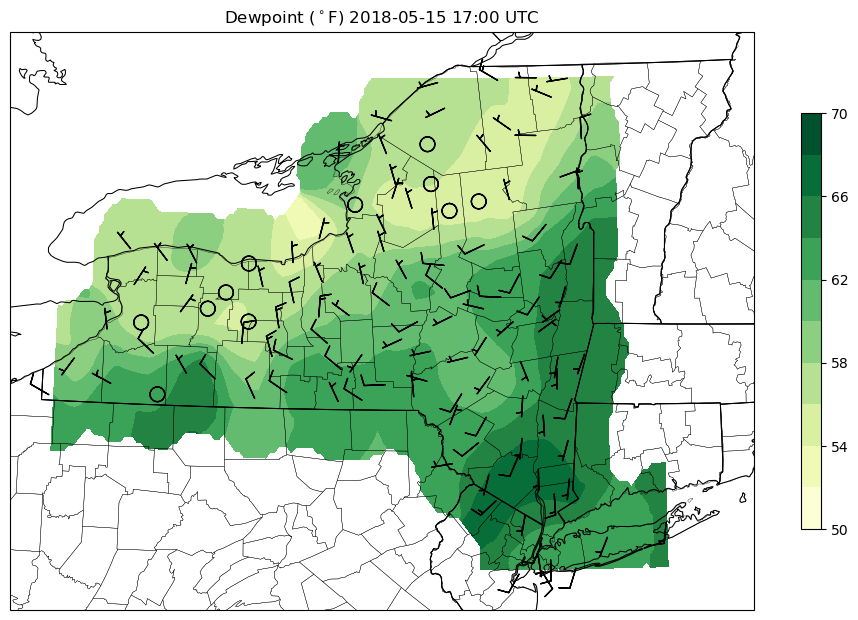

In [44]:
fig = plt.figure(figsize=(12,9,))
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent((-80.0, -71.5, 40.2, 45.2), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)

c = ax.contourf(gridx, gridy, grid_dew, transform=ccrs.PlateCarree(), cmap='YlGn', levels=clevels)
#cl = ax.contour(gridx, gridy, grid_dew, transform=ccrs.PlateCarree(),
               #colors='k', linewidths=1, levels=clevels)

#ax.set_facecolor(cfeature.COLORS['water'])
#ax.add_feature(cfeature.LAND)
#ax.add_feature(cfeature.BORDERS, linestyle='--')
#ax.add_feature(cfeature.LAKES)
#ax.add_feature(cfeature.COASTLINE)
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),fontsize=8)
u, v = mpcalc.wind_components(wspdyes, wdiryes)
stationplot.plot_barb(u, v,zorder=2)

ax.set_title('Dewpoint ($^\circ$F) 2018-05-15 17:00 UTC')
#ax.clabel(cl, inline=True, fontsize=10)
plt.colorbar(c, shrink=0.6)

#region mask python

In [40]:
theta_e_gradient = mpcalc.gradient(grid_the, deltas=(0.1,0.1))

NameError: name 'grid_the' is not defined

In [41]:
plt.scatter(gridx, gridy, c=theta_e_gradient[1])

NameError: name 'theta_e_gradient' is not defined

NameError: name 'theta_e_gradient' is not defined

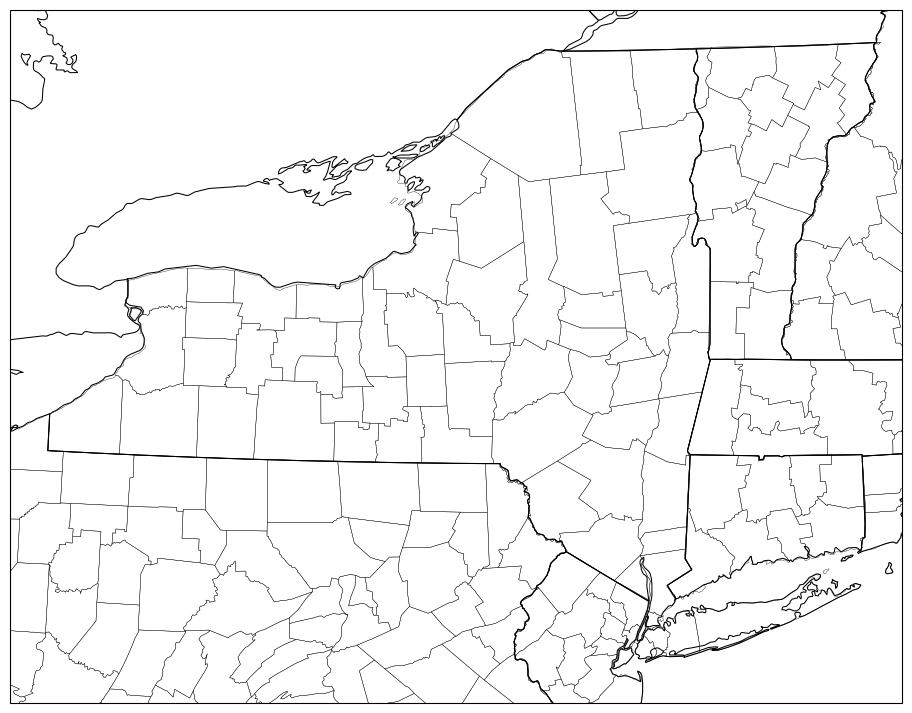

In [42]:
fig = plt.figure(figsize=(12,9,))
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent((-80.0, -71.5, 40.2, 45.2), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)

c = ax.contourf(gridx, gridy, theta_e_gradient[1], transform=ccrs.PlateCarree(), cmap='PuRd_r')
#cl = ax.contour(gridx, gridy, grid_temp, transform=ccrs.PlateCarree(),
               #colors='k', linewidths=1)
stationplot = StationPlot(ax, lons, lats, transform=ccrs.PlateCarree(),fontsize=8)
u, v = mpcalc.wind_components(wspdyes, wdiryes)
stationplot.plot_barb(u, v,zorder=2)

ax.clabel(cl, inline=True, fontsize=10)
ax.set_title('Theta E Gradient 2018-05-15 16:00 UTC')
plt.colorbar(c, shrink=0.6)

#### below is how to calculate the gradient magnitude

In [ ]:
gradient_m = np.sqrt(theta_e_gradient[0]**2 + theta_e_gradient[1]**2)

In [ ]:
plt.scatter(gridx, gridy, c=gradient_m)

In [ ]:
clevels = np.arange(0, 56, 2.5)

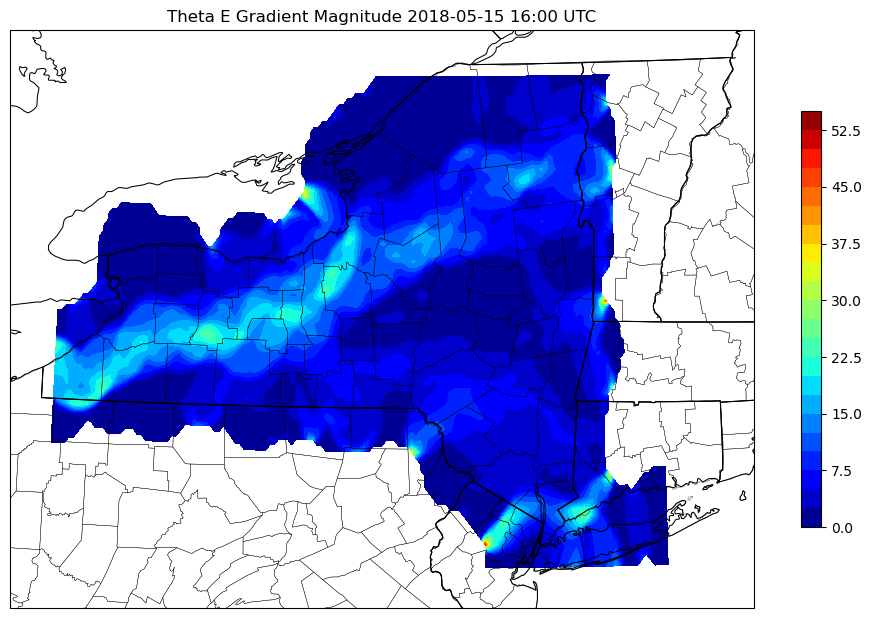

In [94]:
fig = plt.figure(figsize=(12,9,))
ax = fig.add_subplot(1,1,1, projection=crs)
ax.set_extent((-80.0, -71.5, 40.2, 45.2), crs=ccrs.PlateCarree())
ax.add_feature(cfeature.STATES, linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('5m'), linewidth=0.25)

c = ax.contourf(gridx, gridy, gradient_m, transform=ccrs.PlateCarree(), cmap='jet',levels=clevels)
#cl = ax.contour(gridx, gridy, grid_temp, transform=ccrs.PlateCarree(),
               #colors='k', linewidths=1)
ax.clabel(cl, inline=True, fontsize=10)
ax.set_title('Theta E Gradient Magnitude 2018-05-15 16:00 UTC')
plt.colorbar(c, shrink=0.6)